# **Course**: Deep Learning

[<img align="right" width="400" height="100" src="https://www.tu-braunschweig.de/typo3conf/ext/tu_braunschweig/Resources/Public/Images/Logos/tu_braunschweig_logo.svg">](https://www.tu-braunschweig.de/en/)

[Mehdi Maboudi](https://www.tu-braunschweig.de/en/igp/staff/mehdi-maboudi) \([m.maboudi@tu-bs.de](m.maboudi@tu-bs.de)) and [Pedro Achanccaray](https://www.tu-braunschweig.de/en/igp/staff/pedro-diaz) (p.diaz@tu-bs.de)

[Technical University of Braunschweig](https://www.tu-braunschweig.de/en/)  
[Institute of Geodesy and Photogrammetry](https://www.tu-braunschweig.de/igp)

# **Assignment 02:** MLP on shuffled features and how to get reproducible results

## **Comments**

### **1. Shuffle features instead of image columns**

You must shuffle features. In this code, samples and labels are shuffled.

```python
def shuffle_data(x, y):
    num_samples = x.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    return x[indices], y[indices]
```

### **2. Fix all sources of randomness (split, initialization of weights, seeds)**

```python
# Split
x_val, x_test, y_val, y_test = train_test_split(images,
                                                labels,
                                                test_size=0.2,
                                                random_state=42,
                                                stratify=labels)

# Model
def train_and_evaluate(generator,
                       validation_generator,
                       epochs=3):

    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

```



### **3. Use a different model for each experiment (create a function including the `model.compile`)**



```python
for _ in range(3):
    history_shuffled = model.fit(x_train_shuffled,
                                 y_train_shuffled,
                                 epochs=3,
                                 validation_data=(x_val, y_val))

for _ in range(3):
    history_unshuffled = model.fit(x_train,
                                   y_train,
                                   epochs=3,
                                   validation_data=(x_val, y_val))
    
```



## **One possible solution**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import he_normal

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

### **Fix the seeds**

Fix the **seeds** of all **sources of randomness** in your code:
- Dataset split to create train/val/test sets
- Initialization of weights in each layer
- Operations performed by different libraries (Keras, TensorFlow, PyTorch, etc.)

In [ ]:
SEED = 42

def reset_seeds(SEED):
  np.random.seed(SEED)
  tf.random.set_seed(SEED)
  tf.keras.utils.set_random_seed(SEED)

reset_seeds(SEED)

### **Load dataset**

Let's create a function to load the dataset with an option to shuffle or not the features.

In [ ]:
def load_fashion_mnist(shuffle,
                       n_classes,
                       seed):
  """Function to load the Fashion MNIST dataset

  Args:
      shuffle (boolean): If True, the features are randomly shuffled.
      n_classes (int): number of available classes.
      seed (int): seed to fix randomness.

  Returns:
      dictionary: dictionary with features and labels for train,
        validation and test.
  """
  # Load the dataset
  (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

  # shuffle or not the features
  if shuffle:
    shape_train = x_train.shape
    shape_test = x_test.shape
    # Reshape: N x 28 x 28 => N x 784
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    # Shuffle the columns
    idxs = np.random.permutation(x_train.shape[1])
    x_train = x_train[:, idxs]
    x_test = x_test[:, idxs]
    # Reshape: N x 784 => N x 28 x 28
    x_train = x_train.reshape(shape_train)
    x_test = x_test.reshape(shape_test)

  # Train and validation sets
  x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                    y_train,
                                                    test_size=0.2,
                                                    stratify=y_train,
                                                    random_state=seed)

  # Pre-processing images
  x_train = x_train/255.0
  x_val = x_val/255.0
  x_test = x_test/255.0

  # Pre-processing labels
  y_train = to_categorical(y_train, num_classes=n_classes)
  y_val = to_categorical(y_val, num_classes=n_classes)
  y_test = to_categorical(y_test, num_classes=n_classes)

  # dictionary for the outputs
  output = dict()

  output["x_train"] = x_train
  output["y_train"] = y_train
  output["x_val"] = x_val
  output["y_val"] = y_val
  output["x_test"] = x_test
  output["y_test"] = y_test

  return output # x_train, y_train, x_val, y_val, x_test, y_test

Now, we can create two versions of the dataset:
- **`data_no_shuffled`**: Fashion MNIST dataset without any modification to the features.
- **`data_shuffled`**: Fashion MNIST dataset with the features shuffled.

In [ ]:
n_classes = 10

data_no_shuffled = load_fashion_mnist(shuffle=False,
                                      n_classes=n_classes,
                                      seed=SEED)
data_shuffled = load_fashion_mnist(shuffle=True,
                                   n_classes=n_classes,
                                   seed=SEED)

4422102/4422102 [==============================] - 0s 0us/step


### **Visualization**

We can visualize the original image next to the shuffled image.

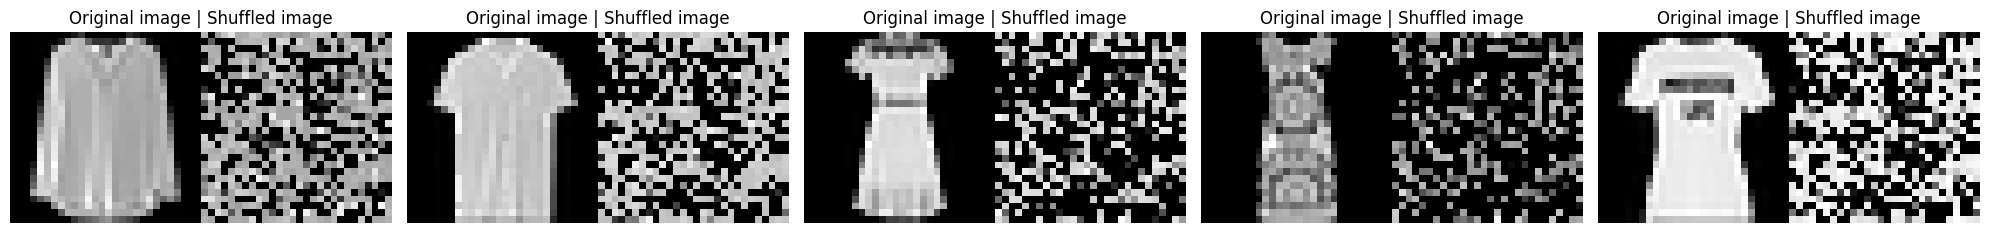

In [ ]:
plt.figure(figsize=(20, 10))

n_samples = 5

for j,(x_no_shuffled,x_shuffled) in enumerate(zip(data_no_shuffled["x_train"],
                                                  data_shuffled["x_train"])):
  img = np.concatenate((x_no_shuffled, x_shuffled), axis=-1)
  plt.subplot(1,n_samples,j+1)
  plt.title("Original image | Shuffled image")
  plt.imshow(img, cmap="gray")
  plt.axis("off")

  if j == (n_samples-1):
    break

plt.tight_layout()
plt.show()

### **Experiments**

The following functions will help us to create a MLP and run the experiments.

In [ ]:
def get_model(hidden_layers,
              n_classes,
              seed):
  """Function to create a Multi layer perceptron.

  Args:
      hidden_layers (np.array): array with the neurons
      for each hidden layer.
      n_classes (int): number of classes.
      seed (int): seed to fix randomness.

  Returns:
      Keras model: a Keras model created using the
      Sequential API.
  """
  model = Sequential()
  # Input layer
  model.add(Flatten(input_shape=(28,28,1)))
  # Hidden layers
  for i in hidden_layers:
    model.add(Dense(i,
                    activation="relu",
                    kernel_initializer=he_normal(seed=seed)))
    model.add(Dropout(rate=0.2, seed=seed))
  # Output layers
  model.add(Dense(n_classes,
                  activation="softmax",
                  kernel_initializer=he_normal(seed=seed)))
  return model


def run_experiment(hidden_layers,
                   data,
                   n_classes,
                   epochs,
                   seed,
                   n_times):
  """Function to train a MLP.

  Args:
      hidden_layers (np.array): array with the neurons
      for each hidden layer.
      data (dict): dictionary with train, validation and
        test splits from the dataset.
      n_classes (int): number of classes.
      epochs (int): number of epochs for training.
      seed (int): seed to fix randomness.
      n_times (int): number of times to repeat
      the experiment

  Returns:
      Keras model: trained model.
  """
  # Run the same experiment many times
  for i in range(n_times):
    reset_seeds(seed)
    print("\nExperiment {}".format(i+1))
    # Create the model
    model = get_model(hidden_layers=hidden_layers,
                      n_classes=n_classes,
                      seed=seed)
    # Compile the  model
    model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                  )
    # Train the model
    history = model.fit(data["x_train"],
                        data["y_train"],
                        epochs=epochs,
                        validation_data=(data["x_val"],data["y_val"]),
                        verbose=1)
  return model

### **Validation: shuffled features**

In [ ]:
hidden_layers=[10, 10]

print("Training without shuffled features:")
model_no_shuffled = run_experiment(hidden_layers,
                                   data=data_no_shuffled,
                                   n_classes=n_classes,
                                   epochs=10,
                                   seed=SEED,
                                   n_times=1)

print("\nTraining with shuffled features:")
model_shuffled = run_experiment(hidden_layers,
                                data=data_shuffled,
                                n_classes=n_classes,
                                epochs=10,
                                seed=SEED,
                                n_times=1)

Training without shuffled features:

Experiment 1
Epoch 1/10
1500/1500 [==============================] - 9s 4ms/step - loss: 1.3433 - accuracy: 0.4730 - val_loss: 0.7630 - val_accuracy: 0.7498
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.9643 - accuracy: 0.6238 - val_loss: 0.6676 - val_accuracy: 0.7923
Epoch 3/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.8748 - accuracy: 0.6643 - val_loss: 0.5966 - val_accuracy: 0.8157
Epoch 4/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.8322 - accuracy: 0.6776 - val_loss: 0.6015 - val_accuracy: 0.8177
Epoch 5/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.8008 - accuracy: 0.6941 - val_loss: 0.5905 - val_accuracy: 0.7998
Epoch 6/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.7838 - accuracy: 0.7004 - val_loss: 0.5855 - val_accuracy: 0.8183
Epoch 7/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.7652 - a

Let's compare the accuracies:

In [ ]:
print("Training without shuffled features:")
model_no_shuffled.evaluate(data_no_shuffled["x_test"],
                           data_no_shuffled["y_test"])

print("\nTraining with shuffled features:")
model_shuffled.evaluate(data_shuffled["x_test"],
                        data_shuffled["y_test"])

Training without shuffled features:
313/313 [==============================] - 1s 3ms/step - loss: 0.5768 - accuracy: 0.8033

Training with shuffled features:
313/313 [==============================] - 1s 3ms/step - loss: 0.5507 - accuracy: 0.8131


[0.5507091283798218, 0.8130999803543091]

The accuracies are **very similar**. So, **what can we conclude** from these results?

### **Validation: fix randomness**

In [ ]:
hidden_layers=[10, 10]

print("Training without shuffled features:")
model_no_shuffled = run_experiment(hidden_layers,
                                   data=data_no_shuffled,
                                   n_classes=n_classes,
                                   epochs=3,
                                   seed=SEED,
                                   n_times=3)

print("\nTraining with shuffled features:")
model_shuffled = run_experiment(hidden_layers,
                                data=data_shuffled,
                                n_classes=n_classes,
                                epochs=3,
                                seed=SEED,
                                n_times=3)

Training without shuffled features:

Experiment 1
Epoch 1/3
1500/1500 [==============================] - 7s 4ms/step - loss: 1.3433 - accuracy: 0.4730 - val_loss: 0.7630 - val_accuracy: 0.7498
Epoch 2/3
1500/1500 [==============================] - 8s 5ms/step - loss: 0.9643 - accuracy: 0.6238 - val_loss: 0.6676 - val_accuracy: 0.7923
Epoch 3/3
1500/1500 [==============================] - 5s 3ms/step - loss: 0.8748 - accuracy: 0.6643 - val_loss: 0.5966 - val_accuracy: 0.8157

Experiment 2
Epoch 1/3
1500/1500 [==============================] - 8s 4ms/step - loss: 1.3433 - accuracy: 0.4730 - val_loss: 0.7630 - val_accuracy: 0.7498
Epoch 2/3
1500/1500 [==============================] - 5s 3ms/step - loss: 0.9643 - accuracy: 0.6238 - val_loss: 0.6676 - val_accuracy: 0.7923
Epoch 3/3
1500/1500 [==============================] - 6s 4ms/step - loss: 0.8748 - accuracy: 0.6643 - val_loss: 0.5966 - val_accuracy: 0.8157

Experiment 3
Epoch 1/3
1500/1500 [==============================] - 7s 4ms/st

# **Lab 03:** Keras APIs

In this lab session, we will see the different APIs provided by Keras to build our models.

## **Load packages and data**

In [ ]:
# Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import he_normal

# Working with arrays
import numpy as np

# Split dataset and shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Visualization
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  stratify=y_train,
                                                  random_state=SEED)
n_classes = 10
# Pre-processing:
x_train = x_train/255.0
x_val = x_val/255.0
x_test = x_test/255.0

y_train = to_categorical(y_train, num_classes=n_classes)
y_val = to_categorical(y_val, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)

## **Data generator**

In this case, we **managed to load** the entire dataset in memory.

**Just for fun**, let's create a data generator for this dataset.

In [ ]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self,
               data,
               labels,
               batch_size,
               n_classes,
               shuffle=True):
    self.data = data
    self.labels = labels
    self.batch_size = batch_size
    self.n_classes = n_classes
    self.shuffle= shuffle

  def on_epoch_end(self):
    if self.shuffle:
      self.data, self.labels = shuffle(self.data, self.labels)

  def __len__(self):
    return np.ceil(self.data.shape[0]/self.batch_size).astype("int")

  def __getitem__(self, idx):
    i = idx * self.batch_size

    current_batch_size = self.batch_size
    if (idx+1) == self.__len__():
      current_batch_size = len(self.path_images[i:])

    batch_images = self.data[i : i + self.batch_size]
    batch_labels = self.labels[i : i + self.batch_size]

    x = np.zeros((self.batch_size,
                  28,
                  28),
                  dtype=np.float32)

    y = np.zeros((self.batch_size,
                  self.n_classes),
                  dtype=np.float32)
    # read data
    for j, (x_sample,y_sample) in enumerate(zip(batch_images,
                                                batch_labels)):
      x[j,...] = x_sample
      y[j,...] = y_sample

    return x, y

In [ ]:
batch_size = 64

data_gen_train = DataGenerator(data=x_train,
                               labels=y_train,
                               batch_size=batch_size,
                               n_classes=n_classes,
                               shuffle=True)

data_gen_val = DataGenerator(data=x_val,
                             labels=y_val,
                             batch_size=batch_size,
                             n_classes=n_classes,
                             shuffle=False)

# For sanity check, let's see the generator's output
for x, y in data_gen_train:
  print(x.shape, y.shape)
  break

(64, 28, 28) (64, 10)


## **Keras APIs**

We have already seen how to implement a MLP model.

For instance, using the following function:

In [ ]:
def get_model_seq(hidden_layers,
                  n_classes,
                  name="my_model"):
  """Function to create a Multi layer perception using the
     Sequential API of Keras.

  Args:
      hidden_layers (np.array): array with the neurons
      for each hidden layer.
      n_classes (int): number of classes.
      name (str): name of the model.

  Returns:
      Keras model: a Keras model created using the
      Sequential API.
  """
  model = Sequential(name=name)
  # Input layer
  model.add(Flatten(input_shape=(28,28,1)))
  # Hidden layers
  for i in hidden_layers:
    model.add(Dense(i,
                    activation="relu"))
    model.add(Dropout(rate=0.2))
  # Output layers
  model.add(Dense(n_classes,
                  activation="softmax"))
  return model

We started by defining an object of the class **`Sequential`**.

Then, we added different layers using the method **`add`**: `model.add(...)`

This is the **Sequential API** of Keras.

**Is there any limitation of the Sequential API?**

**Sequential API**

```python
model = Sequential()
model.add(...)
model.add(...)
```
Simple, better for **lineal models** with a **single input** and a **single output**.


**Functional API**
```python
input_layer = Input(shape=(...))
layer_1 = Dense(...)(input_layer)
layer_2 = Dense(...)(layer_1)
output_layer = Dense(...)(layer_2)
model = Model(inputs=input_layer, outputs=output_layer)
```
More **flexible**, better for complex models with **multiple inputs** and **outputs**.

In [ ]:
def get_model_funct(hidden_layers,
                    n_classes,
                    name="my_model"):
  """Function to create a Multi layer perception using the
     Functional API of Keras.

  Args:
      hidden_layers (np.array): array with the neurons
      for each hidden layer.
      n_classes (int): number of classes.
      name (str): name of the model.

  Returns:
      Keras model: a Keras model created using the
      Functional API.
  """
  # Input layer
  input = Input(shape=(28,28,1))
  # Flatten
  x = Flatten()(input)
  # Hidden layers
  for i in hidden_layers:
    x = Dense(i,
              activation="relu")(x)
    x = Dropout(rate=0.2)(x)
  # Output layers
  output = Dense(n_classes,
                 activation="softmax")(x)
  # Definition of the model
  model = Model(inputs=input,
                outputs=output,
                name=name)
  # model = Model(inputs=[input1, input2,...],
  #               outputs=[output1, output2,...])
  return model

In [ ]:
hidden_layers = [20, 20]

model_sequential = get_model_seq(hidden_layers,
                                 n_classes=n_classes,
                                 name="Sequential_Model")
model_functional = get_model_funct(hidden_layers,
                                   n_classes=n_classes,
                                   name="Functional_Model")

In [ ]:
model_sequential.summary()

Model: "Sequential_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 20)                15700     
                                                                 
 dropout_4 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 20)                420       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_8 (Dense)             (None, 10)                210       
                                                                 
Total params: 16,330
Trainable params: 16,330
Non-

In [ ]:
model_functional.summary()

Model: "Functional_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 20)                15700     
                                                                 
 dropout_6 (Dropout)         (None, 20)                0         
                                                                 
 dense_10 (Dense)            (None, 20)                420       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_11 (Dense)            (None, 10)           

## **Advantages of the Functional API**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, \
                                    Dense, \
                                    Flatten, \
                                    Dropout, \
                                    Conv2D, \
                                    GlobalMaxPooling2D, \
                                    MaxPooling2D, \
                                    Conv2DTranspose, \
                                    UpSampling2D, \
                                    Reshape, \
                                    Average, \
                                    LeakyReLU, \
                                    Concatenate, \
                                    Embedding
from tensorflow.keras.utils import plot_model

### **Models can be called as layers**

For instance, let's see an **Autoencoder** implementation.

An autoencoder is a model where the **input** and the **output** have the **same size**. These models are trained to produce an output similar to the input.

It has two models:
- **Encoder:** extract feature maps from the input while reduces their size.
- **Decoder:** increase the feature map's size to reconstruct the input image.

<center>
<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/0*EGIfbUyHSwJo-Q_2.png" width=700>
</center>



**Denoising autoencoders:**

<center>
<img src="https://b2633864.smushcdn.com/2633864/wp-content/uploads/2020/02/keras_denoising_autoencoder_overview.png?lossy=1&strip=1&webp=1" width=700>
</center>

**Variational autoencoders:**

<center>
<img src="https://substackcdn.com/image/fetch/w_1456,c_limit,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F5e86b196-f761-4f67-8423-88721ffbc0cf_870x537.png" width=700>
</center>

In [ ]:
# Encoder model
encoder_input = Input(shape=(28, 28, 1))
x = Conv2D(16, 3, activation="relu")(encoder_input)
x = Conv2D(32, 3, activation="relu")(x)
x = MaxPooling2D(3)(x)
x = Conv2D(32, 3, activation="relu")(x)
x = Conv2D(16, 3, activation="relu")(x)
encoder_output = GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

# Decoder model
decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = Reshape((4, 4, 1))(decoder_input)
x = Conv2DTranspose(16, 3, activation="relu")(x)
x = Conv2DTranspose(32, 3, activation="relu")(x)
x = UpSampling2D(3)(x)
x = Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

# Autoencoder
autoencoder_input = Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 6, 6, 32)          9248      
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 16)          4624      
                                                           

### **Easy to create ensemble models**

In [ ]:
def get_model():
    inputs = Input(shape=(28,28,1))
    x = Flatten()(inputs)
    x = Dense(50)(x)
    outputs = Dense(10)(x)
    return Model(inputs,
                 outputs)

model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = Input(shape=(28,28,1))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = Average()([y1, y2, y3])
ensemble_model = Model(inputs=inputs,
                       outputs=outputs,
                       name="Ensemble_Model")

model1.summary()
ensemble_model.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 flatten_14 (Flatten)        (None, 784)               0         
                                                                 
 dense_39 (Dense)            (None, 50)                39250     
                                                                 
 dense_40 (Dense)            (None, 10)                510       
                                                                 
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________
Model: "Ensemble_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #   

### **Flexible**

Let's see the case of **Conditional Generative Adversarial Networks (cGANs)**.

<center>
<img src="https://drive.google.com/uc?export=view&id=1AGbZ3C7_UuCH7jIqyXFtL-5epJHQyiJ9" width=900>
</center>

In [ ]:
# Discriminator model
in_shape=(28,28,1)
n_classes = 10

# label input
in_label = Input(shape=(1,))
# embedding for categorical input
li = Embedding(n_classes, 50)(in_label)
# scale up to image dimensions with linear activation
n_nodes = in_shape[0] * in_shape[1]
li = Dense(n_nodes)(li)
# reshape to additional channel
li = Reshape((in_shape[0], in_shape[1], 1))(li)

# image input
in_image = Input(shape=(28,28,1))
# concat label as a channel
merge = Concatenate()([in_image, li])
# downsample
fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
fe = LeakyReLU(alpha=0.2)(fe)
# downsample
fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
fe = LeakyReLU(alpha=0.2)(fe)
# flatten feature maps
fe = Flatten()(fe)
# dropout
fe = Dropout(0.4)(fe)
# output
out_layer = Dense(1, activation='sigmoid')(fe)
# define model
discriminator = Model([in_image, in_label], out_layer)

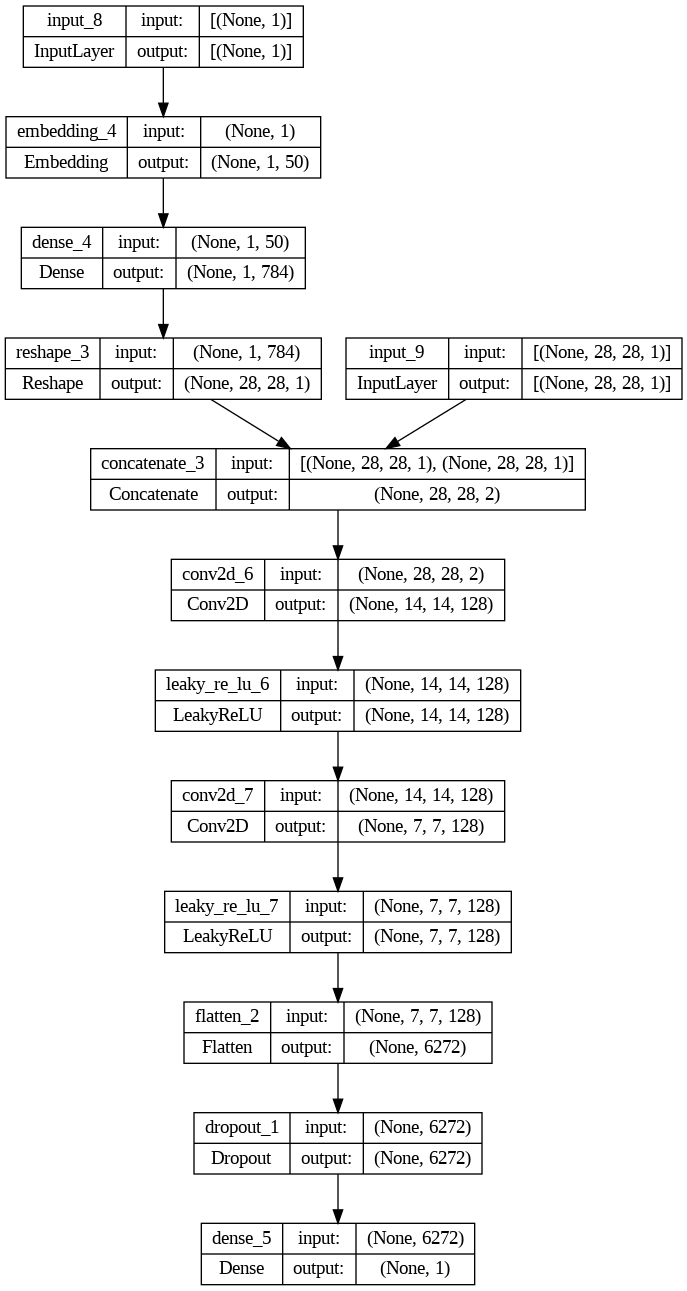

In [ ]:
plot_model(discriminator, to_file="discriminator.png", show_shapes=True)

In [ ]:
# Generator
latent_dim = 100

# label input
in_label = Input(shape=(1,))
# embedding for categorical input
li = Embedding(n_classes, 50)(in_label)
# linear multiplication
n_nodes = 7 * 7
li = Dense(n_nodes)(li)
# reshape to additional channel
li = Reshape((7, 7, 1))(li)
# image generator input
in_lat = Input(shape=(latent_dim,))
# foundation for 7x7 image
n_nodes = 128 * 7 * 7
gen = Dense(n_nodes)(in_lat)
gen = LeakyReLU(alpha=0.2)(gen)
gen = Reshape((7, 7, 128))(gen)
# merge image gen and label input
merge = Concatenate()([gen, li])
# upsample to 14x14
gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
gen = LeakyReLU(alpha=0.2)(gen)
# upsample to 28x28
gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
gen = LeakyReLU(alpha=0.2)(gen)
# output
out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
# define model
generator = Model([in_lat, in_label], out_layer)

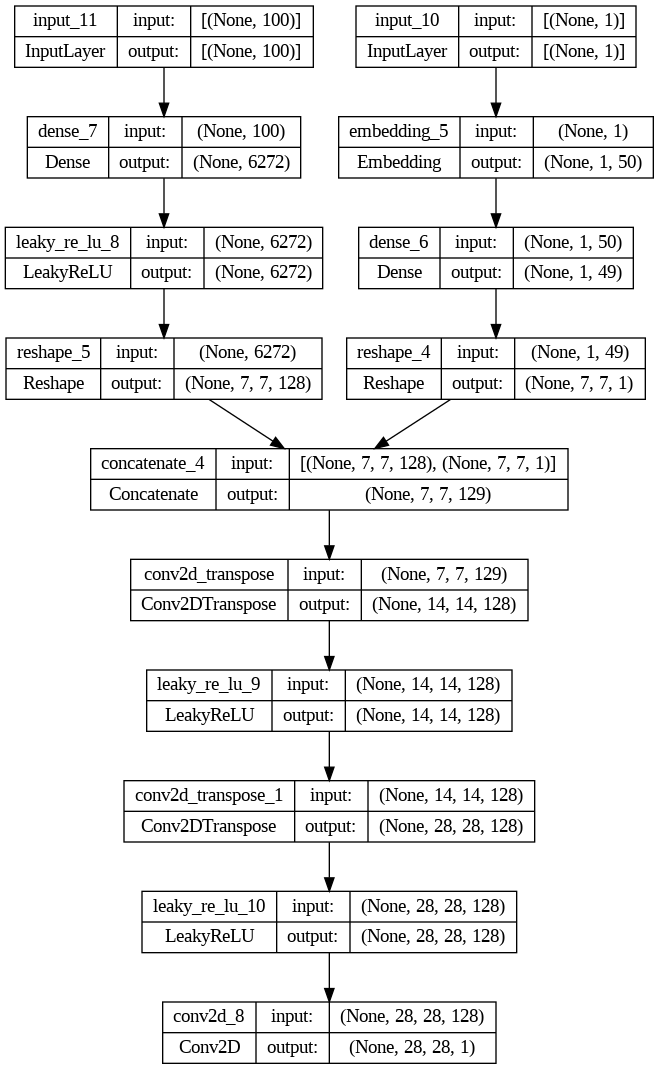

In [ ]:
plot_model(generator, to_file="generator.png", show_shapes=True)

In [ ]:
# get noise and label inputs from generator model
gen_noise, gen_label = generator.input
# get image output from the generator model
gen_output = generator.output
# connect image output and label input from generator as inputs to discriminator
gan_output = discriminator([gen_output, gen_label])
# define gan model as taking noise and label and outputting a classification
gan = Model([gen_noise, gen_label], gan_output)

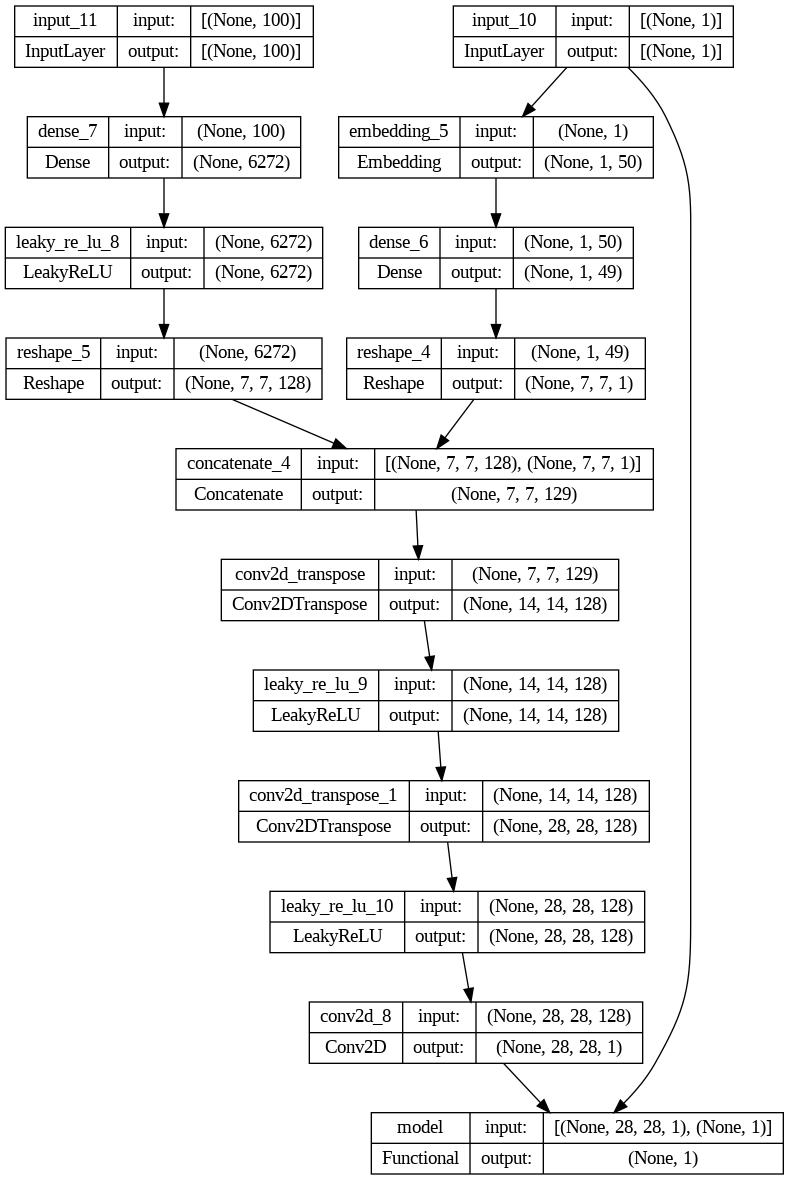

In [ ]:
plot_model(gan, to_file="gan.png", show_shapes=True)